In [1]:
import tensorflow as tf
import loadData
import model
import numpy as np
import glob, sys
import matplotlib.pyplot as plt
import tqdm, os, cv2
%matplotlib inline

sys.path.append("/home/msmith/misc/py/")
sys.path.append("/home/msmith/misc/tfFunctions/")

from dice import dice
from performance import performance
from hStackBatch import hStackBatch
from IPython.display import clear_output

def showBatch(x,y,yPred,unnormalize=1,name=""):
    x, y, yPred = [hStackBatch(im) for im in [x,y,yPred]]
    if unnormalize == 1:
        x *= 255
        y *= 255
        yPred *= 255

    x,y,yPred = [im.astype(np.uint8).squeeze()[:,:,::-1] for im in [x,y,yPred]]
    print("*"*100)
    plt.title(name)
    plt.figure(figsize=(15,15))
    plt.subplot(311)
    plt.imshow(x)
    plt.subplot(312)
    plt.imshow(np.vstack((y,yPred)))
    plt.show()

def mse(y,yPred):
	return tf.reduce_mean(tf.square(tf.sub(y,yPred)))

def trainer(loss,learningRate,momentum=0.9):
    return tf.train.AdamOptimizer(learningRate).minimize(loss)



Using TensorFlow backend.


EPOCH 29 of 30
3.42548739078e-05
****************************************************************************************************


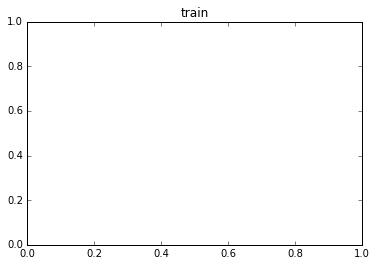

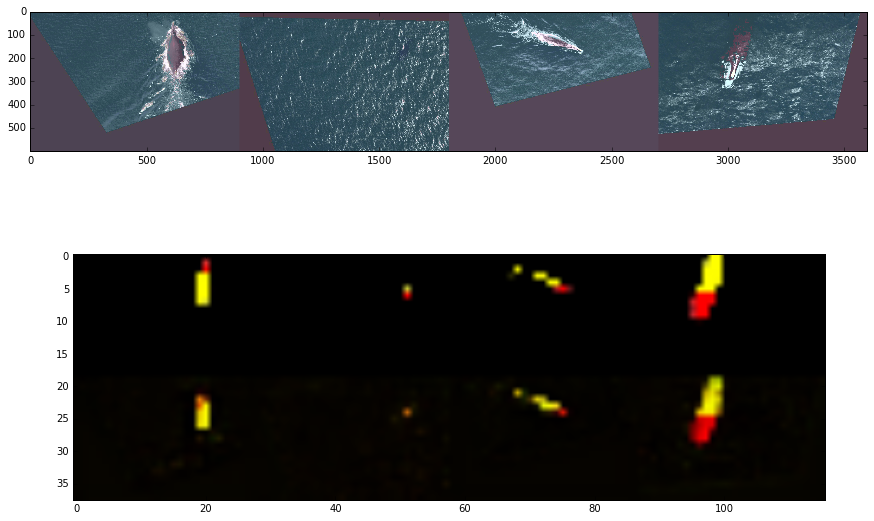

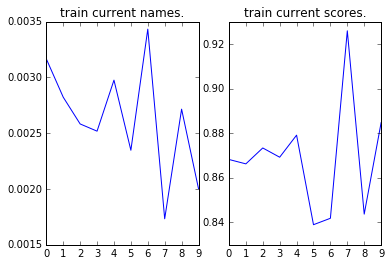

****************************************************************************************************


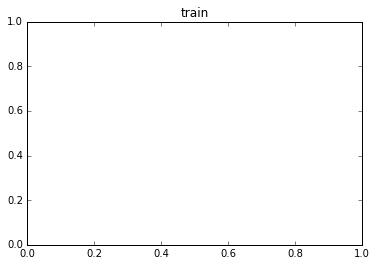

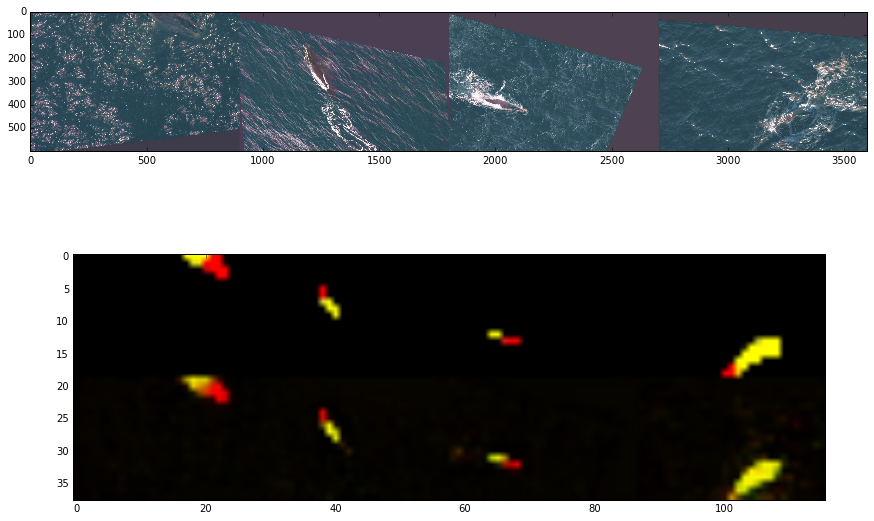

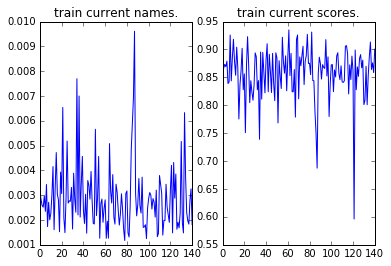

****************************************************************************************************


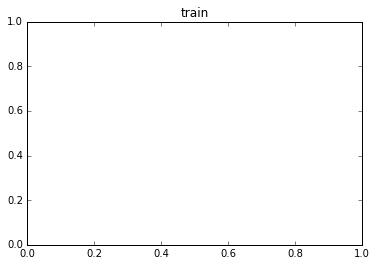

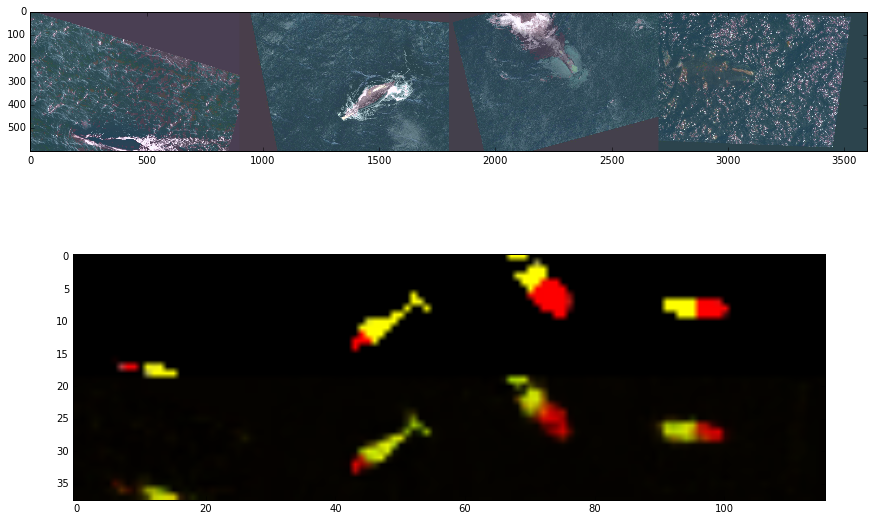

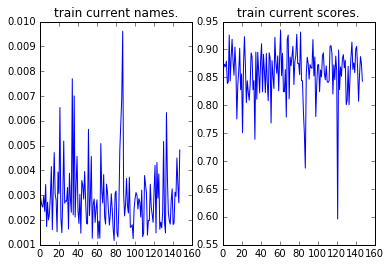

1000 of 6481
****************************************************************************************************


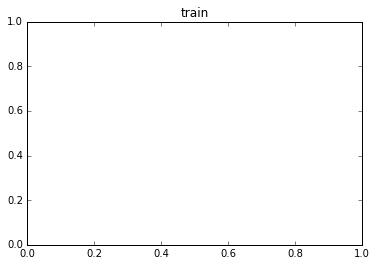

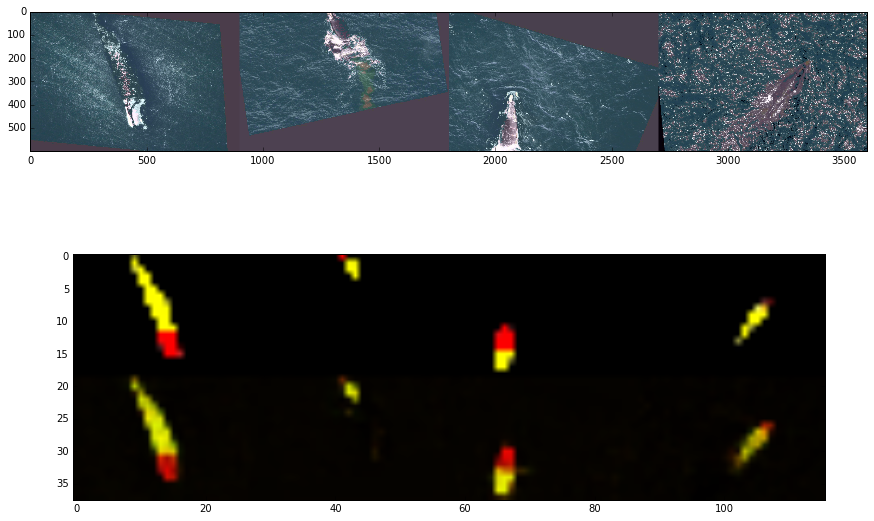

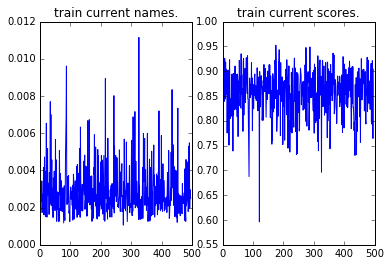

2000 of 6481
3000 of 6481
4000 of 6481
5000 of 6481
****************************************************************************************************


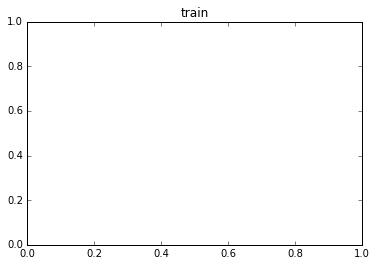

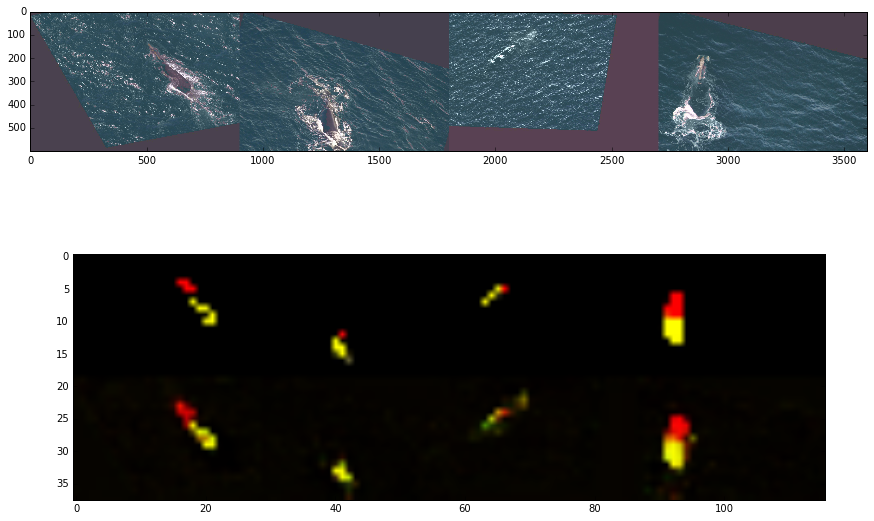

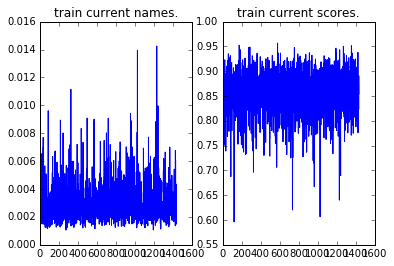

6000 of 6481
0 of 6481
****************************************************************************************************


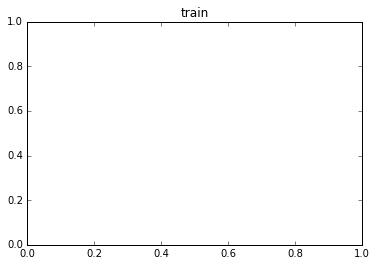

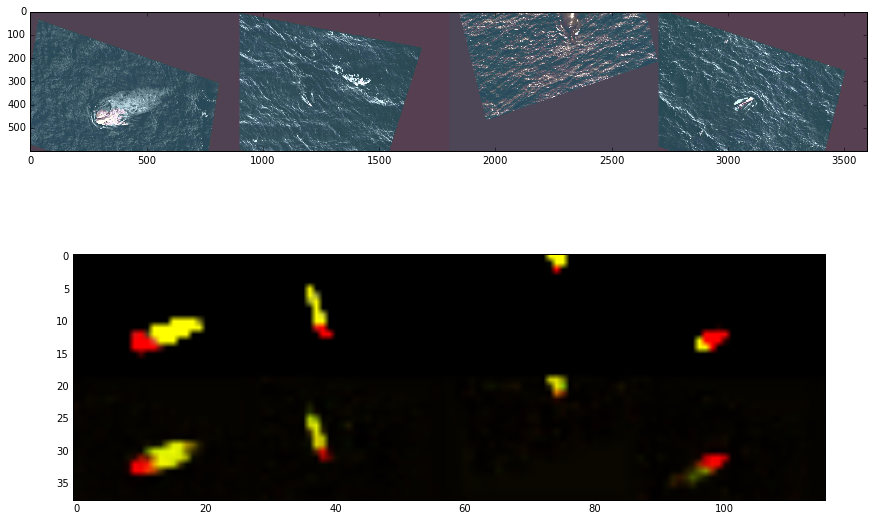

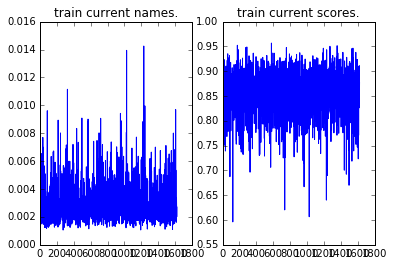

****************************************************************************************************


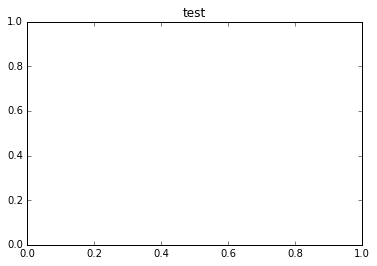

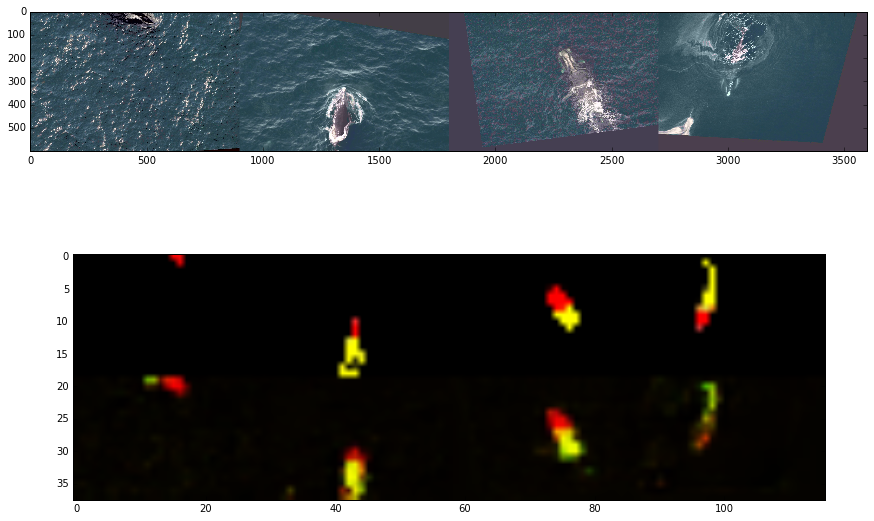

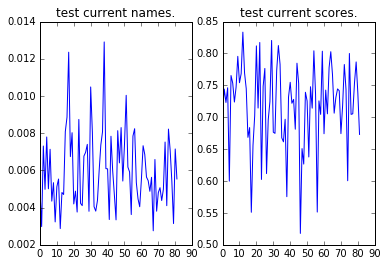

****************************************************************************************************


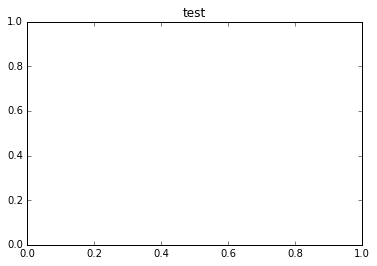

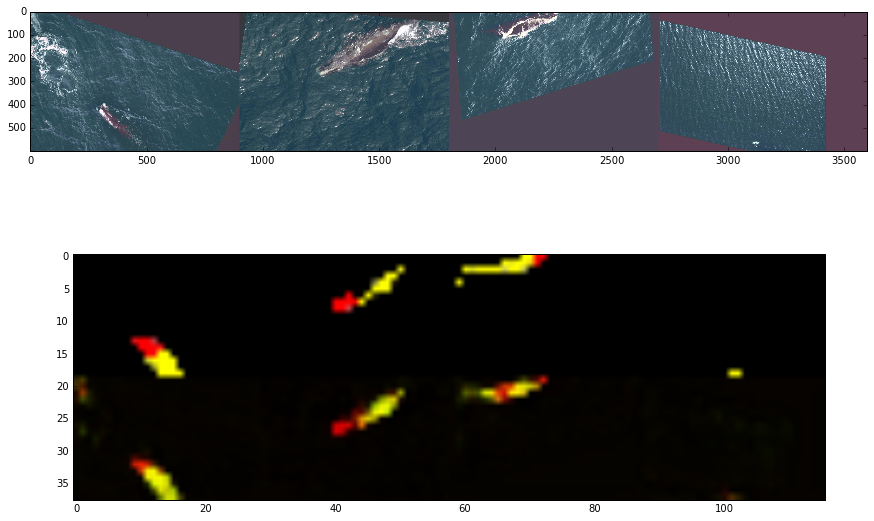

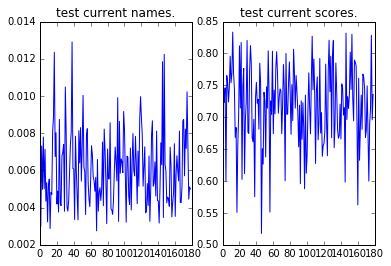

1000 of 1639
****************************************************************************************************


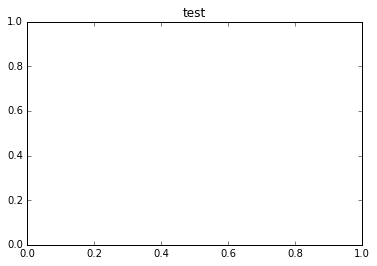

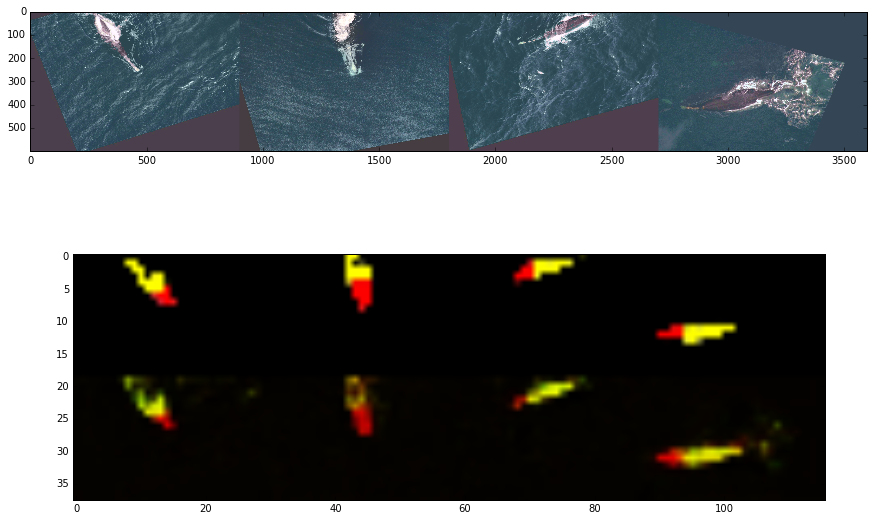

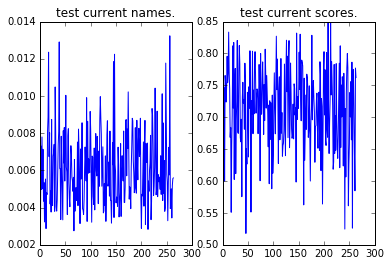

****************************************************************************************************


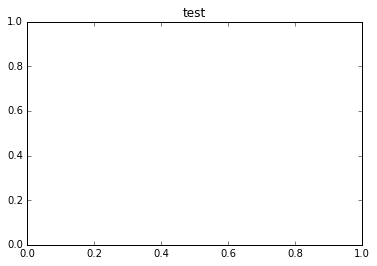

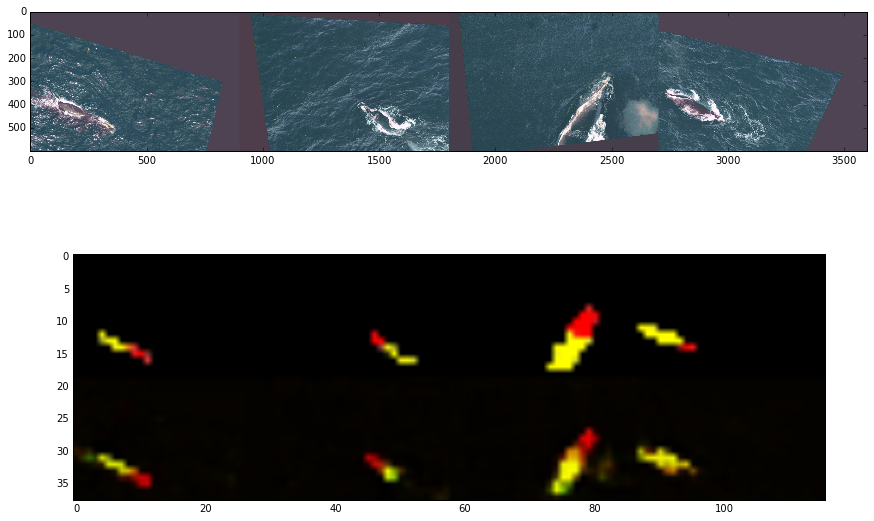

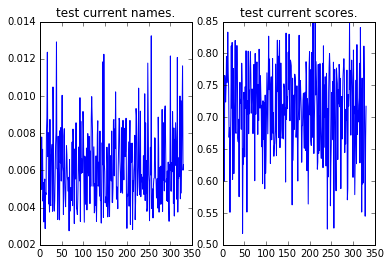

0 of 1639
****************************************************************************************************


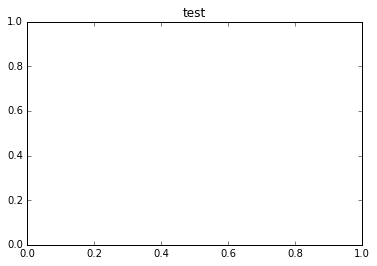

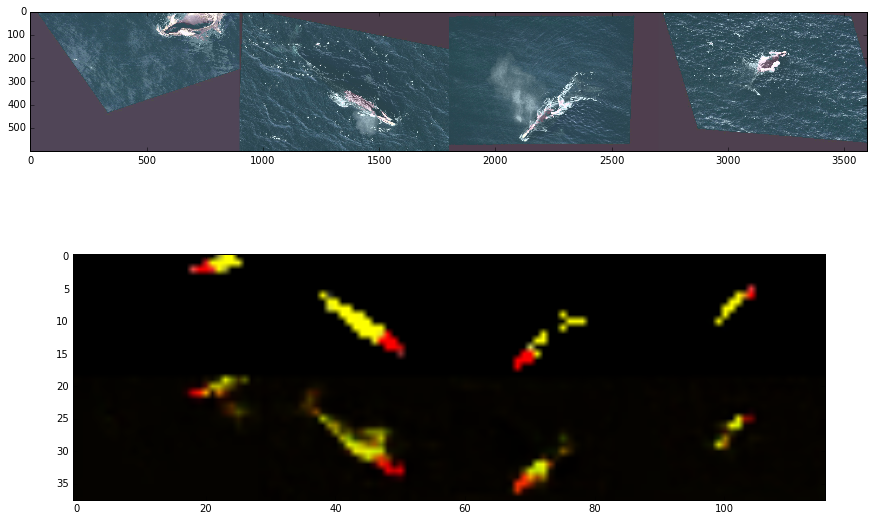

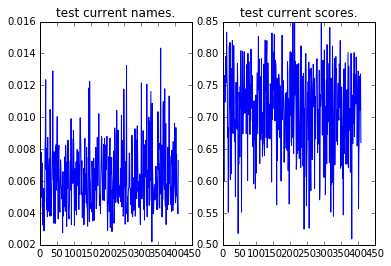

train losses ==> [0.028918324, 0.0080974018, 0.0071433196, 0.006260023, 0.0058166981, 0.0052838451, 0.005062731, 0.0046533104, 0.0044141263, 0.0041434797, 0.0040058186, 0.0037767438, 0.0036909126, 0.0035213723, 0.0034340394, 0.0033239862, 0.0032667264, 0.0031832505, 0.0031586464, 0.0031012879, 0.0030793608, 0.0030360175, 0.0030326711, 0.0030008068, 0.0029884621, 0.0029678904, 0.0029678287, 0.0029540653, 0.0029637169, 0.0029610109]
train scores ==> [0.39930823, 0.54230434, 0.5956471, 0.65396178, 0.68442786, 0.71677905, 0.7302137, 0.75459611, 0.76972657, 0.78502131, 0.79286736, 0.80658984, 0.81253487, 0.82175988, 0.82687134, 0.83434612, 0.83811766, 0.84219217, 0.84427059, 0.84745806, 0.84931326, 0.85170335, 0.85258222, 0.85396534, 0.85524774, 0.85548872, 0.85632604, 0.8569324, 0.85641176, 0.85637105]


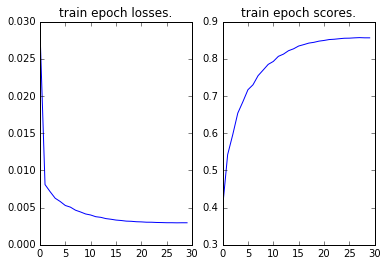

test losses ==> [0.0097992336, 0.0085340058, 0.0078574903, 0.0069813775, 0.0068007456, 0.0066083828, 0.0063801487, 0.0061676786, 0.006163476, 0.0061845472, 0.0062269093, 0.0062153456, 0.0059920102, 0.0061822962, 0.0061634569, 0.0061394796, 0.0061092186, 0.0061899163, 0.0062983115, 0.0062044654, 0.0061272103, 0.0061629433, 0.0061612832, 0.0061907019, 0.0061967699, 0.0061307042, 0.0061329892, 0.0061941147, 0.0061919549, 0.0061988994]
test scores ==> [0.48534289, 0.54274297, 0.60327518, 0.65919495, 0.66836017, 0.68056512, 0.69407904, 0.70906836, 0.70551711, 0.70794624, 0.7076785, 0.70686764, 0.72219515, 0.7106294, 0.7119419, 0.71773237, 0.71729958, 0.71146494, 0.70238054, 0.710199, 0.71324062, 0.71447808, 0.71421087, 0.71185631, 0.71316564, 0.71631426, 0.71796221, 0.71330702, 0.71328586, 0.71206427]


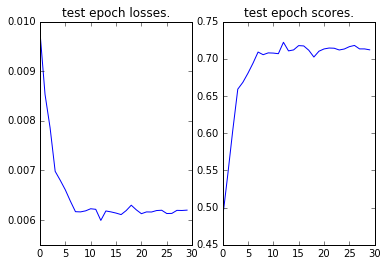

Dropped learning rate to 0.000023
Saving


In [2]:
if __name__ == "__main__":

        import matplotlib.pyplot as plt
        
        # What are we doing?
        trainTest = 1
        fit = 0
        
        # File paths 
        toFitPaths = glob.glob("../../imgs/test/w1S*")
        trPaths = glob.glob("../augmented/train/x_*")
        tePaths = glob.glob("../augmented/test/x_*")
        #trPaths += tePaths # TRAIN ON ALL?!
        
        # Hyperparams
        displayProb = 0.005
        learningRate = 0.01
        load = 0
        save = 1
        diceThreshold = 0.5
        nEpochs = 30
        batchSize = 4
        
        modelName = "modelHistMatch.tf"
        #modelName = "model.tf"
        inDims = [batchSize,600,900,3]
        outDims = [batchSize,19,29,3]
       
        # Graph
        x, y, yPred = model.main()
        loss = mse(yPred,y)
        diceScore, _ = dice(yPred,y,diceThreshold)
        lr = tf.placeholder(tf.float32)
        train = trainer(loss,lr)

        saver = tf.train.Saver()
       
        folderName = "models/bS{0}_in{1}x{2}_out{3}x{4}/".format(batchSize,inDims[1],inDims[2],outDims[1],outDims[2])
        
        if not os.path.exists(folderName):
            os.mkdir(folderName)
        
        with tf.Session() as sess:

            if load == 1: 
                saver.restore(sess,folderName+modelName)
            else:
                init = tf.initialize_all_variables()
                sess.run(init)
            
            if trainTest == 1:
                
                
                # Peformance class
                trPerformance = performance("train")
                tePerformance = performance("test")
                
                # Main train loop
                for epoch in range(nEpochs):
                    clear_output()
                    
                    finTr = finTe = 0
                    print("EPOCH {0} of {1}".format(epoch,nEpochs))
                    print(learningRate)
                    trFeed = loadData.feed(inDims = inDims, outDims = outDims, paths = trPaths)
                    teFeed = loadData.feed(inDims = inDims, outDims = outDims, paths = tePaths)
                    
                    while finTr == 0:
                        X,Y,finTr = trFeed.next()
                        _, loss_, diceScore_, yPred_ = sess.run([train,loss,diceScore,yPred], feed_dict = {x:X,y:Y,lr:learningRate})
                        trPerformance.add(loss_,diceScore_)
                        if finTr == 1 or np.random.uniform() < displayProb:
                            showBatch(X,Y,yPred_,unnormalize=1 , name= "train")
                            trPerformance.displayCurrentPerformance()
                    
                    while finTe == 0:
                        X,Y,finTe = teFeed.next()
                        loss_, diceScore_, yPred_ = sess.run([loss,diceScore,yPred], feed_dict = {x:X,y:Y})
                        tePerformance.add(loss_,diceScore_)
                        if finTe == 1 or np.random.uniform() < displayProb:
                            showBatch(X,Y,yPred_,unnormalize=1, name = "test")
                            tePerformance.displayCurrentPerformance()
                    

                    trPerformance.endEpoch()
                    tePerformance.endEpoch()

                    trPerformance.displayEpochPerformance()
                    tePerformance.displayEpochPerformance()

                    if epoch % 2 == 0 or epoch == nEpochs-1:
                        if epoch > 0:
                            learningRate/= 1.5
                            print("Dropped learning rate to {0:.6f}".format(learningRate))
                        if save == 1:
                            
                            print("Saving")
                            save_path = saver.save(sess, folderName+"/"+modelName)
                            trPerformance.writeToCsv(folderName+"trainPerf.csv")
                            tePerformance.writeToCsv(folderName+"testPerf.csv")
            elif fit == 1:
                inDims[0], outDims[0] = 1,1 # One at a time 
                for paths in [toFitPaths[:50]]:
                    print("*"*100)
                    paths = paths
                    fitFeed = loadData.feed(inDims = inDims, outDims = outDims, paths = paths)       
                    finFitting = 0
                    count = 0
                    while finFitting == 0:
                        X,_,finFitting = fitFeed.next()
                        yPred_ = sess.run([yPred], feed_dict = {x:X})
                        #if np.random.uniform() < displayProb:
                        plt.figure(figsize=(10,20))
                        yPred_ = yPred_[0].squeeze()
                        yPredU = cv2.resize(yPred_,(X.shape[2],X.shape[1]))
                        both = np.hstack((X.squeeze()[:,:,::-1],yPredU))*255
                        both = both.astype(np.uint8)
                        plt.imshow(both)
                        plt.show()
                        cv2.imwrite(folderName+"eg"+str(count)+".jpg",both)
                        count +=1
